In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2 import Artifact

from skbio.diversity import beta_diversity, alpha_diversity
from skbio.stats import distance, ordination
from skbio.stats.composition import clr

from scipy.cluster import hierarchy
from scipy.spatial import distance

from biom import Table

%matplotlib inline

# Read in Data

In [31]:
metadata = pd.read_csv("../metadata/mapping.tsv", sep="\t")

metabo_metadata = metadata.set_index("MetaboSampleID")



## Aqueous

In [32]:
aqueous = pd.read_csv("../metabolome/Aqueous_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T

raw_indexes        = [x for x in list(aqueous.index) if ("Log2(normalized)" not in x)]
normalized_indexes = [x for x in list(aqueous.index) if ("(raw)" not in x)]

raw_aqueous = aqueous.loc[raw_indexes]
log_aqueous = aqueous.loc[normalized_indexes]

raw_aqueous.index = [int(x.split("SBAQ_")[-1][:-5]) if ("SBAQ_" in x)
                     else x 
                     for x in list(raw_aqueous.index)]

log_aqueous.index = [int(x.split("SBAQ_")[-1][:-18]) if ("SBAQ_" in x)
                     else x 
                     for x in list(log_aqueous.index)]

metabo_info_cols = ['Compound Name','Retention Time', 'Measured Retention Time', 
                    'Product Mass','QualifierMass', 'CASNumber', 
                    'CompoundType', 'ISTDCompoundName', 'Mass Column']

raw_aqueous_samples = raw_aqueous.drop(metabo_info_cols).sort_index()
log_aqueous_samples = log_aqueous.drop(metabo_info_cols).sort_index()

## Lipid

In [33]:
lipid = pd.read_csv("../metabolome/Lipid_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T
lipid.head()

raw_lipid_indexes =        [x for x in list(lipid.index) if ("Log2(normalized)" not in x)]
normalized_lipid_indexes = [x for x in list(lipid.index) if ("(raw)" not in x)]

raw_lipid = lipid.loc[raw_lipid_indexes]
log_lipid = lipid.loc[normalized_lipid_indexes]

raw_lipid.index = [int(x.split("Lipid_")[-1][:-5]) if ("Lipid_" in x)
                     else x 
                     for x in list(raw_lipid.index)]

log_lipid.index = [int(x.split("Lipid_")[-1][:-18]) if ("Lipid" in x)
                     else x 
                     for x in list(log_lipid.index)]

raw_lipid_samples = raw_lipid.drop(metabo_info_cols).sort_index()
log_lipid_samples = log_lipid.drop(metabo_info_cols).sort_index()

In [34]:
# adding this because index isn't showing up as int type
raw_aqueous_samples.index = [int(x) for x in list(raw_aqueous_samples.index)]
raw_lipid_samples.index = [int(x) for x in list(raw_lipid_samples.index)]

## Microbiome

In [35]:
microbiome = Artifact.load("../microbiome/tax_filtered_GT.qza").view(pd.DataFrame)

tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
tax = tax.to_dict()["Taxon"]
microbiome.rename(columns=tax, inplace=True) # map OTUs to taxonomy name

microbiome_mat = np.matrix(microbiome)
microbiome_mat /= microbiome_mat.sum(axis=1) #convert to relative abundances

microbiome = pd.DataFrame(microbiome_mat, columns=microbiome.columns, index=microbiome.index)

In [36]:
microbiome_index_mapper = metadata.set_index("#SampleID")["MetaboSampleID"].to_dict()

new_microbiome_index = [int(microbiome_index_mapper[x]) for x in list(microbiome.index)]
microbiome.index = new_microbiome_index
microbiome = microbiome.sort_index()

# Presence/Absence correlation

## Make presence/absence

In [37]:
def make_presence_absence(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0

In [38]:
presence_aqueous_samples = pd.DataFrame(index = raw_aqueous_samples.index)
presence_lipid_samples = pd.DataFrame(index = raw_lipid_samples.index)
presence_microbiome = pd.DataFrame(index = microbiome.index, columns=microbiome.columns)

for col in raw_aqueous_samples.columns:
    presence_aqueous_samples[col] = raw_aqueous_samples[col].apply(lambda x: make_presence_absence(x, threshold=0.00001))
    
for col in raw_lipid_samples.columns:
    presence_lipid_samples[col] = raw_lipid_samples[col].apply(lambda x: make_presence_absence(x, threshold=0.00001))

for col in microbiome.columns:
    presence_microbiome[col] = microbiome[col].apply(lambda x: -1 * (-x//1)) #ceiling division to convert to presence


## Correlation

In [39]:
from scipy.stats import spearmanr, pearsonr

In [40]:
all_presence = pd.concat([presence_microbiome, presence_aqueous_samples, presence_lipid_samples], axis=1)

In [41]:
all_presence_corr = np.matrix(all_presence.corr(method="spearman"))


In [42]:
microbiome_psuedo = pd.DataFrame(microbiome_mat+0.0001, 
                                 index=microbiome.index, columns=microbiome.columns)
clr_microbiome = pd.DataFrame(clr(microbiome_psuedo), 
                              index=microbiome.index, columns=microbiome.columns)

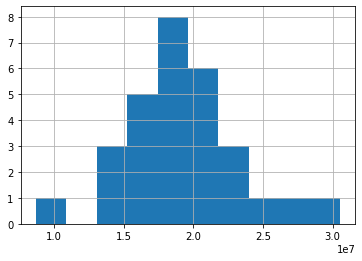

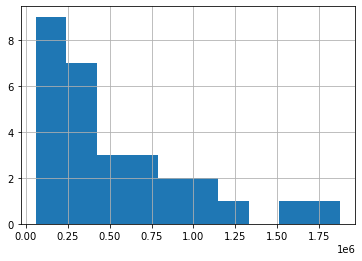

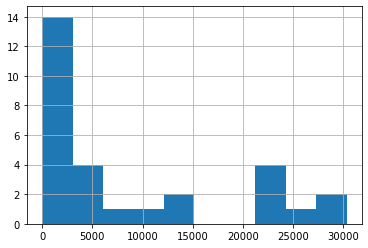

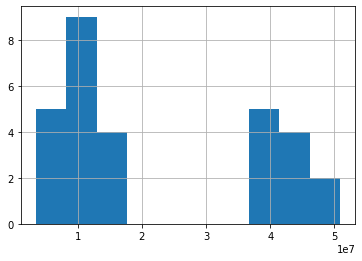

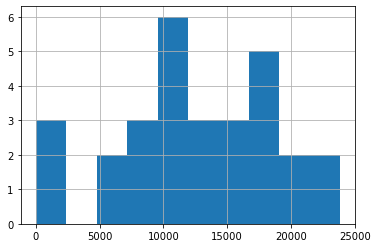

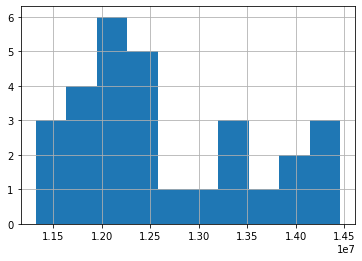

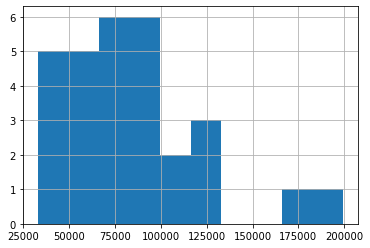

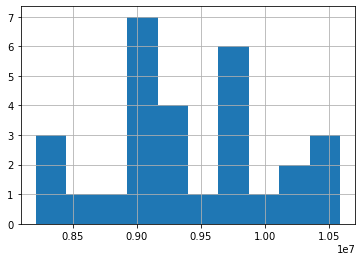

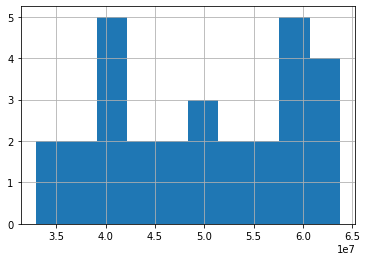

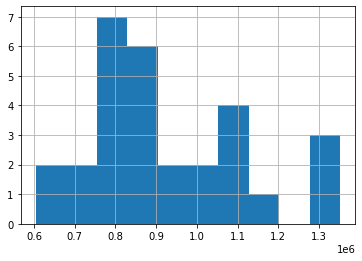

In [43]:
for i in range(10):
    raw_aqueous_samples.iloc[:,i].hist()
    plt.show()

In [86]:
all_data = pd.concat([clr_microbiome, raw_aqueous_samples, raw_lipid_samples], axis=1).apply(pd.to_numeric)

In [88]:
all_pearson = all_data.corr(method="pearson")

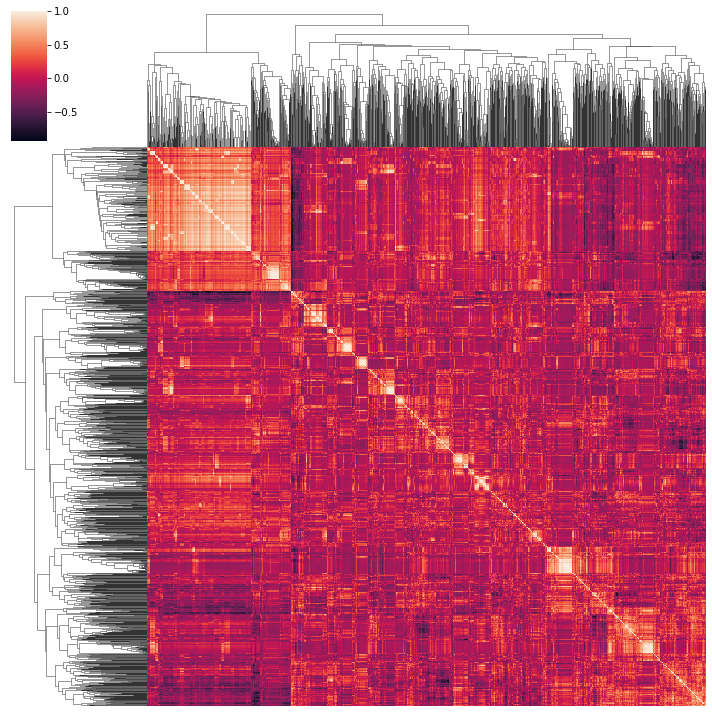

In [89]:
ax = sns.clustermap(all_pearson, xticklabels=False, yticklabels=False)

In [98]:
array_of_pearson_corr = all_pearson.to_numpy().flatten()

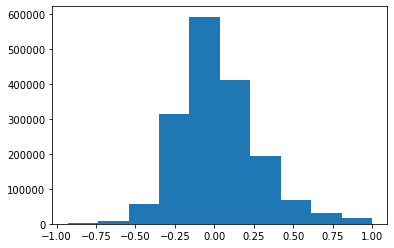

In [99]:
plt.hist(array_of_pearson_corr)
plt.show()

In [104]:
array_of_pearson_corr_noself = array_of_pearson_corr[np.where(array_of_pearson_corr<1)]
for i in np.arange(70,100,5):
    print(f"The {i}th percentile of pearson correlation coefficients is {np.percentile(array_of_pearson_corr_noself, q=i)}")

The 70th percentile of pearson correlation coefficients is 0.12116249991314311
The 75th percentile of pearson correlation coefficients is 0.1615959890365321
The 80th percentile of pearson correlation coefficients is 0.20838684615116138
The 85th percentile of pearson correlation coefficients is 0.26486838735027257
The 90th percentile of pearson correlation coefficients is 0.34133889883326174
The 95th percentile of pearson correlation coefficients is 0.4776059634095738


In [106]:
all_pearson.to_csv("../microbiome/all_pearson.tsv", sep="\t")

## Network

In [56]:
import networkx as nx

In [91]:
G = nx.from_pandas_edgelist(all_pearson)

KeyError: 'source'

In [64]:
all_data

,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Ruminococcus; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae; g__; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Christensenellaceae; g__; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Oscillospira; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Anaerofilum; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Oscillospira; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Christensenellaceae; g__; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Clostridium; s__clostridioforme,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae; g__Clostridium; s__paraputrificum,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Ruminococcus; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Dorea; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__uniformis,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__copri,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__[Ruminococcus]; s__gnavus,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Rikenellaceae; g__Alistipes; s__putredinis,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__ovatus,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Rikenellaceae; g__; s__,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Rikenellaceae,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Blautia,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae; g__Clostridium; s__septicum,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Porphyromonadaceae; g__Parabacteroides; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Oscillospira; s__,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Peptostreptococcaceae; g__[Clostridium]; s__bifermentans,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__[Ruminococcus]; s__torques,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Oscillospira; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Ruminococcus; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae; g__SMB53; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Dorea; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Clostridium; s__citroniae,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Anaerofilum; s__,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__[Odoribacteraceae]; g__Butyricimonas; s__,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae,...,"DG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/16:0/0:0)_6.509",C164